In [1]:
#pip install pyro-ppl

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, NUTS, MCMC
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam


pyro.set_rng_seed(1)

torch.manual_seed(1)
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
from sklearn.datasets import load_iris

X, y = load_iris(as_frame=True, return_X_y=True)
X['type'] = y
# type_names = ['setosa', 'versicolor', 'virginica']

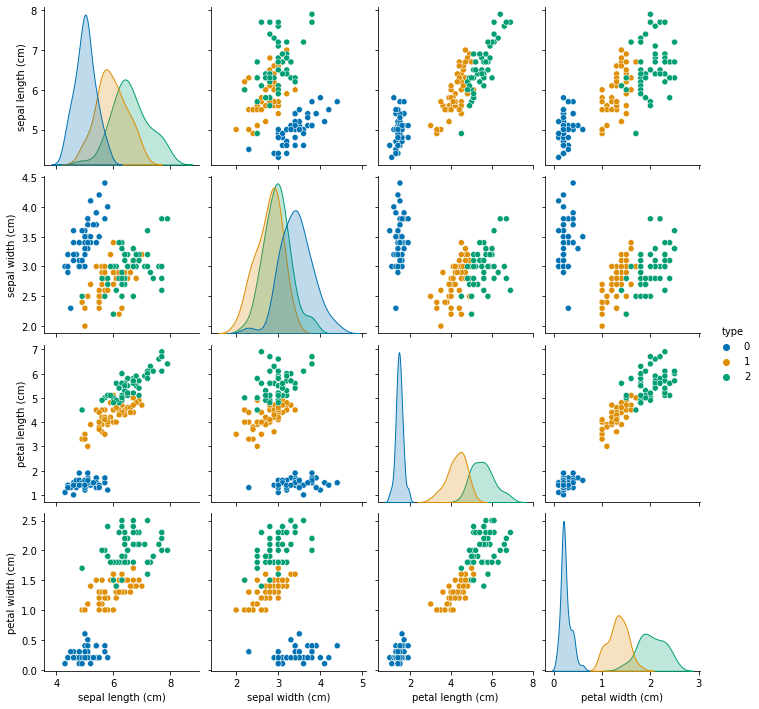

In [4]:
sns.pairplot(data=X, hue='type', palette="colorblind", corner=False);

## Linear Regression with Iris Data

### So this dataset gives us a lot of different data to model

### Let's start off with a simple linear regression and let's model petal width as a function of petal length
### Performing a Linear Regression 'petal width ~ petal length'

In [5]:
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'type'],
      dtype='object')

In [6]:
X_ = tensor(X.values)
data = X_[:,2]
target = X_[:,3]
data_column_names = X.columns[2:4]
data_column_names

Index(['petal length (cm)', 'petal width (cm)'], dtype='object')

In [7]:
# We are going to make a Bayesian Linear Regression Model using Pyro, and solve it using the PyTorch infra

In [8]:
def model_1(data, target):
    intercept_prior = 0.0 # goes through the origin. If it didn't, add a dist for the intercept prior

    beta = pyro.sample("beta", dist.Uniform(0., 2.)) #beta prior. Determined by data scientist

    mean = intercept_prior + (data * beta)
    
    sigma_1 = pyro.sample('sigma',dist.Exponential(0.25)) #sigma prior. Determined by data scientist

    with pyro.plate('data', target.size(0)): #plate makes one draw for each data point
      pyro.sample('obs', dist.Normal(mean, sigma_1), obs=target)



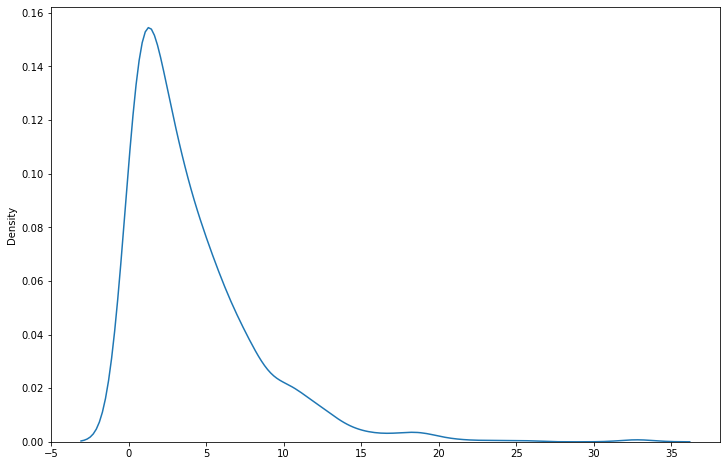

In [9]:
#Aside Why Exponential(0.25) for the sigma prior?

sns.kdeplot(dist.Exponential(0.25).sample([1000]));

In [10]:
guide = AutoMultivariateNormal(model_1) #Pyro has a convenient set of autoguides available. One can also write custom guides.

def train(model, guide, lr=0.01, n_steps=1500):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")

In [11]:
%%time
train(model_1, guide) #Question: Should I train my guide for more steps? Why or why not?

Elbo loss: 521.3491788543735
Elbo loss: 19.077900501183713
Elbo loss: 18.61768055905322
CPU times: total: 1min 18s
Wall time: 14.3 s


In [12]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model_1, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

In [13]:
svi_samples.keys()

dict_keys(['beta', 'sigma'])

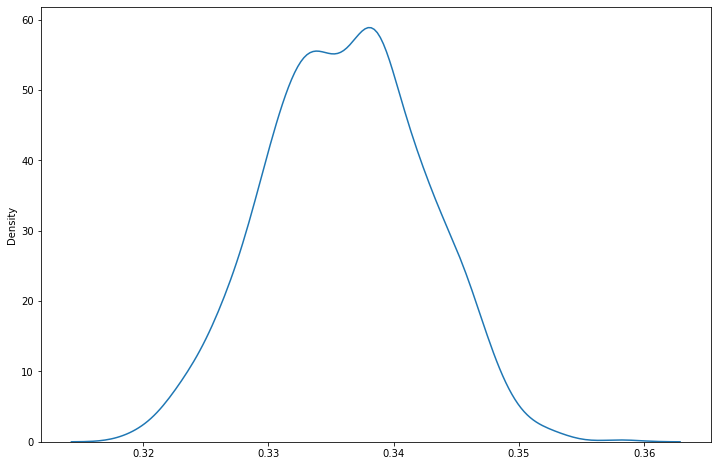

In [14]:
sns.kdeplot(svi_samples['beta']);

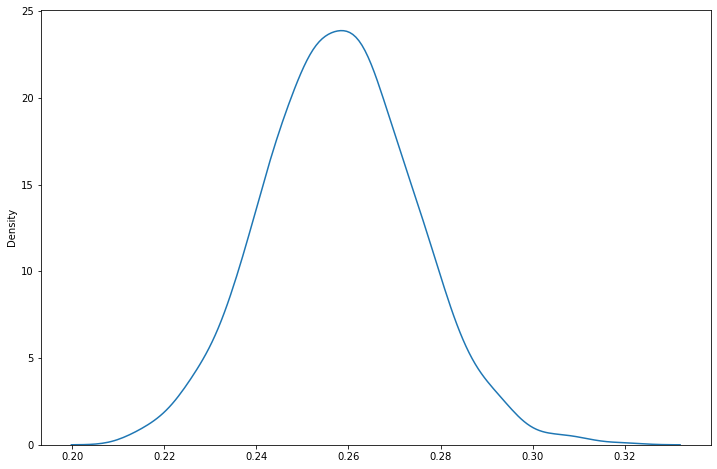

In [15]:
sns.kdeplot(svi_samples['sigma']);

In [16]:
svi_samples['beta'].mean(), scipy.stats.mode(svi_samples['beta'])[0] # Beta symmetric, mean = mode

(0.33616772, array([0.34098536], dtype=float32))

(0.0, 7.0)

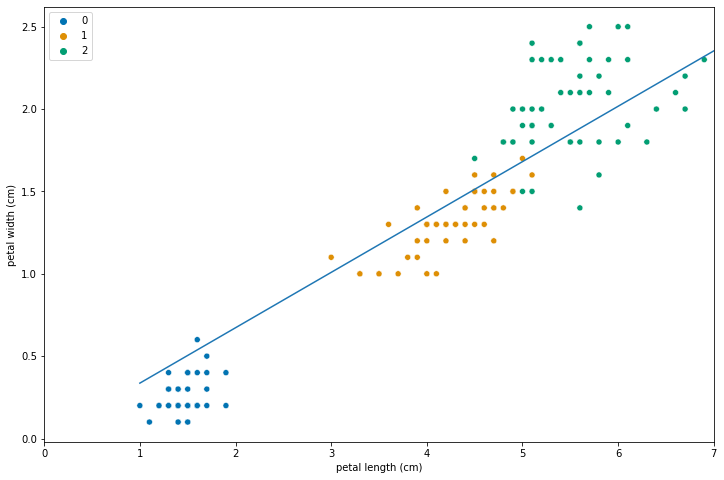

In [17]:
xx = np.linspace(1,7,50)
yy = (svi_samples['beta'].mean()) * xx #draw a line through the mean of the predicted slope estimates
ax = sns.scatterplot(x='petal length (cm)', y='petal width (cm)', palette='colorblind', hue='type', data=X)
sns.lineplot(x=xx, y=yy, ax=ax)
plt.xlim(0,7)

(0.0, 7.0)

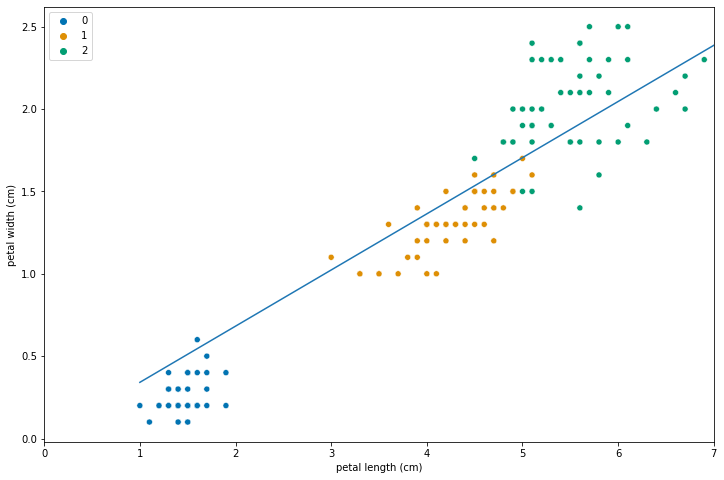

In [18]:
xx = np.linspace(1,7,50)
yy = scipy.stats.mode(svi_samples['beta'])[0] * xx #draw a line through the mode of the predicted slope estimates
ax = sns.scatterplot(x='petal length (cm)', y='petal width (cm)', palette='colorblind', hue='type', data=X)
sns.lineplot(x=xx, y=yy, ax=ax)
plt.xlim(0,7)

### Perform MCMC on the same dataset


In [19]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model_1)
mcmc = MCMC(nuts_kernel, num_samples=600, warmup_steps=100)

In [20]:
# no change. Just copied here for convenience
data = X_[:,2]
target = X_[:,3]
data_column_names = X.columns[2:4]
data_column_names

Index(['petal length (cm)', 'petal width (cm)'], dtype='object')

In [21]:
%%time
mcmc.run(data, target)

Sample: 100%|██████████████████████████████████████████| 700/700 [00:14, 48.25it/s, step size=8.36e-01, acc. prob=0.934]                    

CPU times: total: 1min 21s
Wall time: 14.5 s


In [22]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [23]:
hmc_samples.keys() # output stored in dict

dict_keys(['beta', 'sigma'])

In [24]:
hmc_samples['beta'].mean(), scipy.stats.mode(hmc_samples['beta'][0]) # mode is ever so slightly larger than the mean.

(0.33643012342664236, ModeResult(mode=array([0.34070746]), count=array([1])))

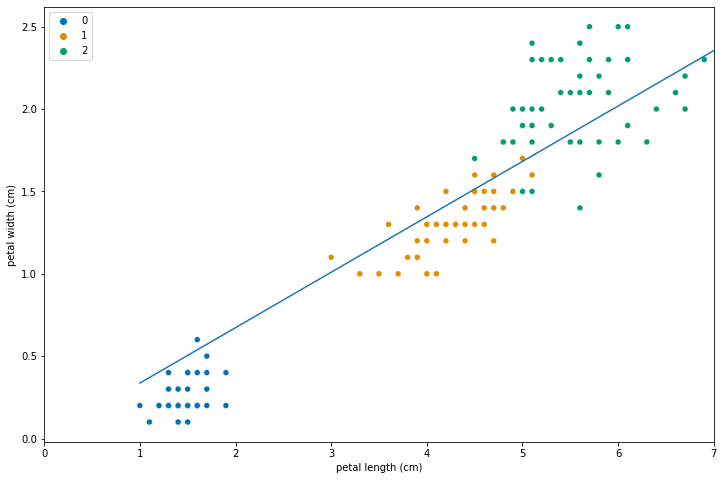

In [25]:
# virtually identical
xx = np.linspace(1,7,50)
yy_mean = (hmc_samples['beta'].mean()) * xx
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', palette='colorblind', hue='type', data=X)
sns.lineplot(x=xx, y=yy_mean)
plt.xlim(0,7);

## Footnotes
### Notice that I did not center the data. This is a no-no! 
*Always center your data*! Do as I say, not as I do.
Centering the data helps you properly interpret the parameters of the (multiple) linear regression. 
Centering might also help model convergence in general, although since the variables are all the same order of magnitude, probably would not matter in this case

### Notice that I calculated the MEAN slope of the posterior samples. 
If you re-did this using scikit learn or statsmodels OLS, you would retrieve the **maximium likelihood estimate** of the slope. The answer retrieved would be 'close' to our answer above, but different! 

In [26]:
#Final Note:  there is no free lunch! MCMC is generally much slower for big data.

#HOWEVER, If you need a more exact answer of where the posterior lies, use MCMC, since MCMC does a better job than SVI and the autoguides.
# If you want to use SVI you're going to have to pay close attention to the construction of your guide!
# That's all I'll say about SVI and guides for now. Come back in a few weeks when I know more!

## Logistic Regression with Iris Data

see logistic regression demo notebook